![](header.jpg)

# MLX90640 IR Thermal Camera

Kevin J. Walchko

28 June 2020

---


![](https://cdn.sparkfun.com//assets/parts/1/3/0/1/4/SparkFun_MLX90640_Thermal_Imaging_Camera-Demo.gif)

![](https://cdn-learn.adafruit.com/assets/assets/000/087/351/large1024/adafruit_products_MLX90640_110_vs_55.jpg?1579733757)

MLX90640 IR Thermal Camera

 - 24x32 pixel IR image
 - Target temperature range 40-300C
 - Optics: 55x35 or 110x70
 - 16 Hz @ 800k I2C speed operations (theoretical 32Hz)
 - Address: 0x33
 - FT232H dev tree:
     - macOS: /dev/tty.usbserial-1440
     - linux: TBD

## Install

```
brew install libusb       # macOS
apt install libusb-1.0.0  # Ubuntu
```

```
pip install pyftdi adafruit-blinka
pip install adafruit-circuitpython-mlx90640
```

## Reference

- Adafruit Product: [MLX90640 IR Thermal Camera](https://www.adafruit.com/product/4407)
- Adafruit Learn: [Adafruit MLX90640 IR Thermal Camera](https://learn.adafruit.com/adafruit-mlx90640-ir-thermal-camera?view=all)
- Sparkfun tutorial: [MLX90640 Hookup](https://learn.sparkfun.com/tutorials/qwiic-ir-array-mlx90640-hookup-guide)
- Laptop connector: [FT232H USB to I2C](https://www.adafruit.com/product/2264)
- Github: [adafruit-circuitpython-mlx90640](https://github.com/adafruit/Adafruit_CircuitPython_MLX90640)
- [Datasheet](MLX90640-Datasheet-Melexis.pdf)

In [1]:
# Since I am doing this on my mac laptop, I am using
# the FT232H board to connect to the I2C camera
import os
if 'BLINKA_FT232H' in os.environ.keys():
    pass
else:
    os.environ['BLINKA_FT232H'] = "1"

In [2]:
import time
import board
import busio
import adafruit_mlx90640
import numpy as np
from collections import deque
from colorama import Fore
from pyftdi.i2c import I2cNackError

In [8]:
import matplotlib.pyplot as plt

## Matplotlib

Let's grab an image and plot it

### Setup

I setup the camera with some other I2C sensors (ignore them). You can see the camera in the lower right (SparkX), but it is the same as the Adafruit one.

![](camera.png)

In [6]:
# access camera
i2c = busio.I2C(board.SCL, board.SDA, frequency=100000)
mlx = adafruit_mlx90640.MLX90640(i2c)
mlx.refresh_rate = adafruit_mlx90640.RefreshRate.REFRESH_2_HZ

In [11]:
def grab():
    # grab image 24x32 pixel ir image and return numpy image
    frame = [0] * 24*32
    mlx.getFrame(frame)
    return np.array(frame).reshape((24,32))

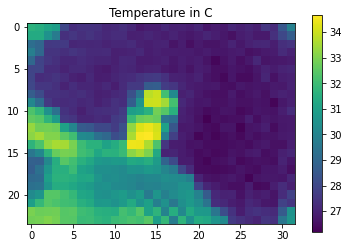

In [17]:
f = grab()
plt.imshow(f)
plt.title("Temperature in C")
plt.colorbar();

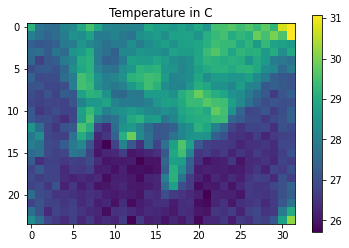

In [19]:
f = grab()
plt.imshow(f)
plt.title("Temperature in C")
plt.colorbar();

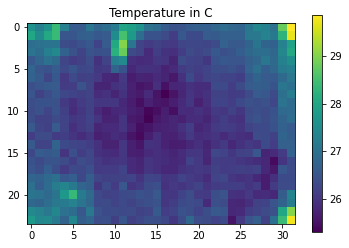

In [20]:
f = grab()
plt.imshow(f)
plt.title("Temperature in C")
plt.colorbar();

## Command Line

Run from the command line using `colorama` to print colors. Unicode allows us to print a square, using the code `\u2588`, and setting the fore ground color:

```
cool [black, blue, cyan, green, yellow, red] hot
```

In [34]:
class Scale:
    # maps temperatures to colorama colors
    s = {
        25: f"{Fore.BLACK}\u2588",
        27: f"{Fore.BLUE}\u2588",
        29: f"{Fore.CYAN}\u2588",
        31: f"{Fore.GREEN}\u2588",
        33: f"{Fore.YELLOW}\u2588",
        35: f"{Fore.RED}\u2588",
    }
    
    def __call__(self, t):
        for k,v in self.s.items():
            if t < k:
                return v
        return f"{Fore.RED}\u2588"

In [36]:
d = deque([f"{Fore.BLACK}\u2588"]*32,32)
f = grab()
scale = Scale()

for i, t in enumerate(f.reshape((24*32,))):
    if i%32 == 0:
        print("".join(d))
    d.append(scale(t))
print(Fore.RESET)

████████████████████████████████
████████████████████████████████
████████████████████████████████
████████████████████████████████
████████████████████████████████
████████████████████████████████
████████████████████████████████
████████████████████████████████
████████████████████████████████
████████████████████████████████
████████████████████████████████
████████████████████████████████
████████████████████████████████
████████████████████████████████
████████████████████████████████
████████████████████████████████
████████████████████████████████
████████████████████████████████
████████████████████████████████
████████████████████████████████
████████████████████████████████
████████████████████████████████
████████████████████████████████
████████████████████████████████



## Raspberry Pi

![](cameras.jpeg)

I have also successfully run this code on the Pi. Above is am image of my Pi with a normal PiCamera and the IR camera mounted next to each other.

Setting the Pi to 400Hz by changing `/boot/config.txt` to `dtparam=i2c_arm=on,i2c_arm_baudrate=400000`. Then setting camera to internally operate at 8Hz with `mlx.refresh_rate = adafruit_mlx90640.RefreshRate.REFRESH_8_HZ` lets me read the camera at 4Hz. This is because the camera reads the sensor twice, every other line (inerlaced in old TV terms), so 8Hz internal camera read, gives me 4Hz images.

Whe I try to do `mlx.refresh_rate = adafruit_mlx90640.RefreshRate.REFRESH_16_HZ`, I get a read error. I probably have to set my Pi to 800Hz but you don't seem to be able to do that.